# Creating a model and training it for generating and clustering music

In [1]:
#TODO: Create models: VAE, WAE, U-NET
#Save model weights
#Evaluate in this file?

In [2]:
#libraries
import deeplay as dl
import deeptrack as dt
import torch
import os
from PIL import Image, ImageOps
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Preprocess data
data_dir = os.path.expanduser("./trainImagesSmall")

#Load image files using ImageFolder
#trainFiles = dt.sources.ImageFolder(root=data_dir)
trainFilesSmall = dt.sources.ImageFolder(root=data_dir)

print(f"Number of train images: {len(trainFilesSmall)}")

Number of train images: 10000


In [4]:
#Create image pipeline
class CropWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, x: torch.Tensor):
        return x[..., :self.target_width]
    
image_pip = (dt.LoadImage(trainFilesSmall.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float) >> CropWidth(512
             ))

In [5]:
img_tensor = image_pip(trainFilesSmall.path[0])
print(f"The size of each image is: {img_tensor.shape}")

The size of each image is: torch.Size([1, 512, 512])


In [ ]:
#VAE
from deeplay import AdamW #Specifically importing AdamW so we can easily change it to something else like SGDM //BD
import torch

#Even with very small beta the KL loss seems to decrease while the rec loss stays steady, suggesting the network is not able to learn the latent space //BD

from variationalAutoEncoder import VariationalAutoEncoder

vae = VariationalAutoEncoder(input_size=(512,512),
    latent_dim=150, channels=[32, 64, 128, 256],
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"), beta=1, optimizer=AdamW(lr=1e-4)
).create()


vae.encoder.blocks[0].layer.kernel_size = (5,5)
vae.encoder.blocks[1].layer.kernel_size = (5,5)
vae.encoder.blocks[2].layer.kernel_size = (5,5)
vae.encoder.blocks[3].layer.kernel_size = (5,5)
vae.decoder.blocks[0].layer.kernel_size = (5,5)
vae.decoder.blocks[1].layer.kernel_size = (5,5)
vae.decoder.blocks[2].layer.kernel_size = (5,5)
vae.decoder.blocks[3].layer.kernel_size = (5,5)
#vae.decoder.add_module("Dropout",torch.nn.Dropout(0.2))


print(vae)


In [6]:
import dataset #Imported modified dataset code
#train_dataset = dataset.Dataset(image_pip & image_pip, inputs=trainFiles)
batch_size = 1
train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs = "oneSong")
train_loader = dl.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=15)

In [ ]:
effective_batch_size = 256
grad_batches = int(effective_batch_size/batch_size)

In [ ]:

vae_trainer = dl.Trainer(max_epochs=20, accelerator="auto")
vae_trainer.fit(vae, train_loader)

### Plotting the training progress and saving the model

In [ ]:
import torch
vae_trainer.history.plot()
torch.save(vae.state_dict(), "vae.pth")  #Saving the model.
#vae.load_state_dict(torch.load("vae.pth"))  // Use this to load the weights into a new model //BD

In [7]:
#WAE, let us just focus on the VAE for now, later we can use this code
wae = dl.WassersteinAutoEncoder(input_size=[512,512],
    channels=[16, 32, 64, 128, 256], latent_dim=128,
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"), optimizer=dl.AdamW(lr=1e-4)
).create()

wae.decoder.blocks[4].activation = torch.nn.Identity()

print(wae)

WassersteinAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Conv2dBlock(
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Conv2dBlock(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchN

/home/rasmus/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 393 K  | train
1 | fc_enc              | Linear                 | 33.6 M | train
2 | fc_dec              | Linear                 | 33.8 M | train
3 | decoder             | ConvolutionalDecoder2d | 392 K  | train
4 | reconstruction_loss | MSELoss                | 0      | train
5 | train_metrics       | MetricCollection       | 0      | train
6 | val_metrics         | MetricCollection       | 0      | train
7 | test_metrics        | MetricCollection       | 0      | train
8 | optimizer           | AdamW                  | 0      | train
-----------------------------------------------------------------------
68.2 M  

Epoch 99: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s, v_num=493, train_rec_loss_step=nan.0, train_mmd_loss_step=nan.0, train_rec_loss_epoch=nan.0, train_mmd_loss_epoch=nan.0]


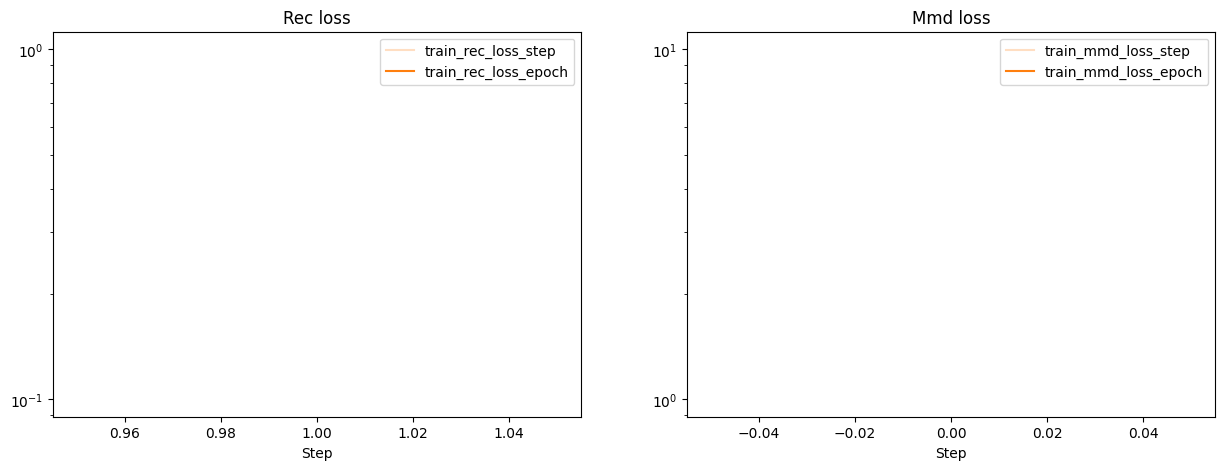

In [8]:
#effective_batch_size = 256
#grad_batches = int(effective_batch_size/batch_size)

wae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
wae_trainer.fit(wae, train_loader)
import torch
wae_trainer.history.plot()
torch.save(wae.state_dict(), "wae.pth")

In [ ]:
#Example on how to generate music, just random noise now but with proper training and clustering we could try to sample things adjacent to a genre //BD
"""
--------------------------
THIS IS OUTDATED DON'T USE
--------------------------
"""
import torch
from Image2Sound import Image2Sound, SaveAudio
from torchvision.utils import save_image

vae.eval()  
n_samples = 1 
latent_dim = 20  
#Had to add a scalar to make the volume higher, think because of the normalization in the pipeline //BD
z = 255*torch.randn(n_samples, latent_dim).to(next(vae.parameters()).device)
print(z.shape)

with torch.no_grad():
    generated_image = vae.decode(z)
    #TODO: Change the Image2Sound so we don't have to define conf again here when generating, should be a simple enough fix. Alternatively just make a file holding the class
    #with a proper init //BD
    class conf:
        sampling_rate = 44100
        duration = 30
        hop_length = 694
        fmin = 20
        fmax = sampling_rate // 2
        n_mels = 128
        n_fft = n_mels * 20
        samples = sampling_rate * duration
    save_image(generated_image, 'generated_sample.jpg')
    audio = Image2Sound('generated_sample.jpg', conf)
    SaveAudio(audio,os.getcwd(),"testing.mp3")
